## Todo - visualization solutions
- plot categorical (one-by-one)
- plot categorical (deep downsampling)

In [1]:
import json
import h5py
import tqdm
import datetime
import time
import pandas as pd
import numpy as np
import collections

import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd2/fangming/projects/SingleCellRoutines')

import __init__plots
importlib.reload(__init__plots)
from __init__plots import *

import snmcseq_utils
importlib.reload(snmcseq_utils)

import utils
importlib.reload(utils)

import datashader as ds
import colorcet

import powerplot
importlib.reload(powerplot)

import _powerplot_vizgen_merfish
importlib.reload(_powerplot_vizgen_merfish)
from _powerplot_vizgen_merfish import *

In [2]:
today = datetime.date.today()
figures = '../figures/{}_{{}}'.format(today)
results = '../data/{}_{{}}'.format(today)
figures, results

('../figures/2021-05-29_{}', '../data/2021-05-29_{}')

# read in processed data
- cell metadata
- cell gene matrix (normalized)
- cell clusters and umap
- palette and other metadata

In [3]:
# palette as json
file = '../data/palette.json'
with open(file, 'r') as f:
    palette = json.load(f)
palette

{'Slice1_Replicate1': [0.19215686274509805,
  0.5098039215686274,
  0.7411764705882353],
 'Slice1_Replicate2': [0.4196078431372549,
  0.6823529411764706,
  0.8392156862745098],
 'Slice1_Replicate3': [0.6196078431372549,
  0.792156862745098,
  0.8823529411764706],
 'Slice2_Replicate1': [0.9019607843137255,
  0.3333333333333333,
  0.050980392156862744],
 'Slice2_Replicate2': [0.9921568627450981,
  0.5529411764705883,
  0.23529411764705882],
 'Slice2_Replicate3': [0.9921568627450981,
  0.6823529411764706,
  0.4196078431372549],
 'Slice3_Replicate1': [0.19215686274509805,
  0.6392156862745098,
  0.32941176470588235],
 'Slice3_Replicate2': [0.4549019607843137,
  0.7686274509803922,
  0.4627450980392157],
 'Slice3_Replicate3': [0.6313725490196078,
  0.8509803921568627,
  0.6078431372549019]}

In [4]:
!ls ../data/*.tsv.gz

../data/clustering_embedding_S1R1_S1R2_S1R3_S2R1_S2R2_S2R3_S3R1_S3R2_S3R3_2021-05-22.tsv.gz
../data/clustering_embedding_S1R2_2021-05-22.tsv.gz
../data/clustering_embedding_S2R1_2021-05-22.tsv.gz
../data/clustering_embedding_S2R1_S1R2_2021-05-22.tsv.gz
../data/clustering_embedding_Slice1_Replicate2_2021-05-18.tsv.gz
../data/clustering_embedding_Slice2_Replicate1_2021-05-15.tsv.gz


In [5]:
f = '../data/clustering_embedding_S1R1_S1R2_S1R3_S2R1_S2R2_S2R3_S3R1_S3R2_S3R3_2021-05-22.tsv.gz'
clsts = pd.read_csv(f, sep='\t').set_index('cell')
clsts['cluster_cat'] = pd.Categorical(clsts['cluster']) #.astype
print(clsts.shape)
clsts.head()

(692682, 5)


cluster    umap_1     umap_2  \
cell                                                                   
110883424764611924400221639916314253469     C14  1.417047   9.138863   
135188247894899244046039873973964001182     C14  1.260269   8.663673   
164766962839370328502017156371562646881     C14 -0.179721  10.929612   
165747897693809971960756442245389760838     C14  0.770016  10.161936   
260943245639750847364278545493286724628     C14  0.422456  10.411513   

                                                    sample cluster_cat  
cell                                                                    
110883424764611924400221639916314253469  Slice1_Replicate1         C14  
135188247894899244046039873973964001182  Slice1_Replicate1         C14  
164766962839370328502017156371562646881  Slice1_Replicate1         C14  
165747897693809971960756442245389760838  Slice1_Replicate1         C14  
260943245639750847364278545493286724628  Slice1_Replicate1         C14

In [6]:
input = '../data/processed_vizgen_merfish_may22_2021.hdf5'
samples = [
    'Slice1_Replicate1',
    'Slice1_Replicate2',
    'Slice1_Replicate3',
    
    'Slice2_Replicate1',
    'Slice2_Replicate2',
    'Slice2_Replicate3',
    
    'Slice3_Replicate1',
    'Slice3_Replicate2',
    'Slice3_Replicate3',
]

samples_shortname = "_".join([
    sample.replace('Slice', 'S').replace('_Replicate', 'R')
    for sample in samples
])

for sample in samples:
    gmat = []
    meta = []
    for sample in samples:
        _gmat = pd.read_hdf(input, 'mat_'+sample)
        gmat.append(_gmat)
        _meta = pd.read_hdf(input, 'meta_'+sample)
        _meta['sample'] = sample 
        meta.append(_meta)
gmat = pd.concat(gmat)
meta = pd.concat(meta)


In [7]:
# informations
thedata = clsts.drop('sample', axis=1).join(meta) #.join(clsts)
genes = gmat.columns
thedatagmat = thedata.join(gmat)
print(len(genes), gmat.shape, thedata.shape)

483 (692682, 483) (692682, 17)


### Run gene viz

  0%|          | 0/1 [00:00<?, ?it/s]

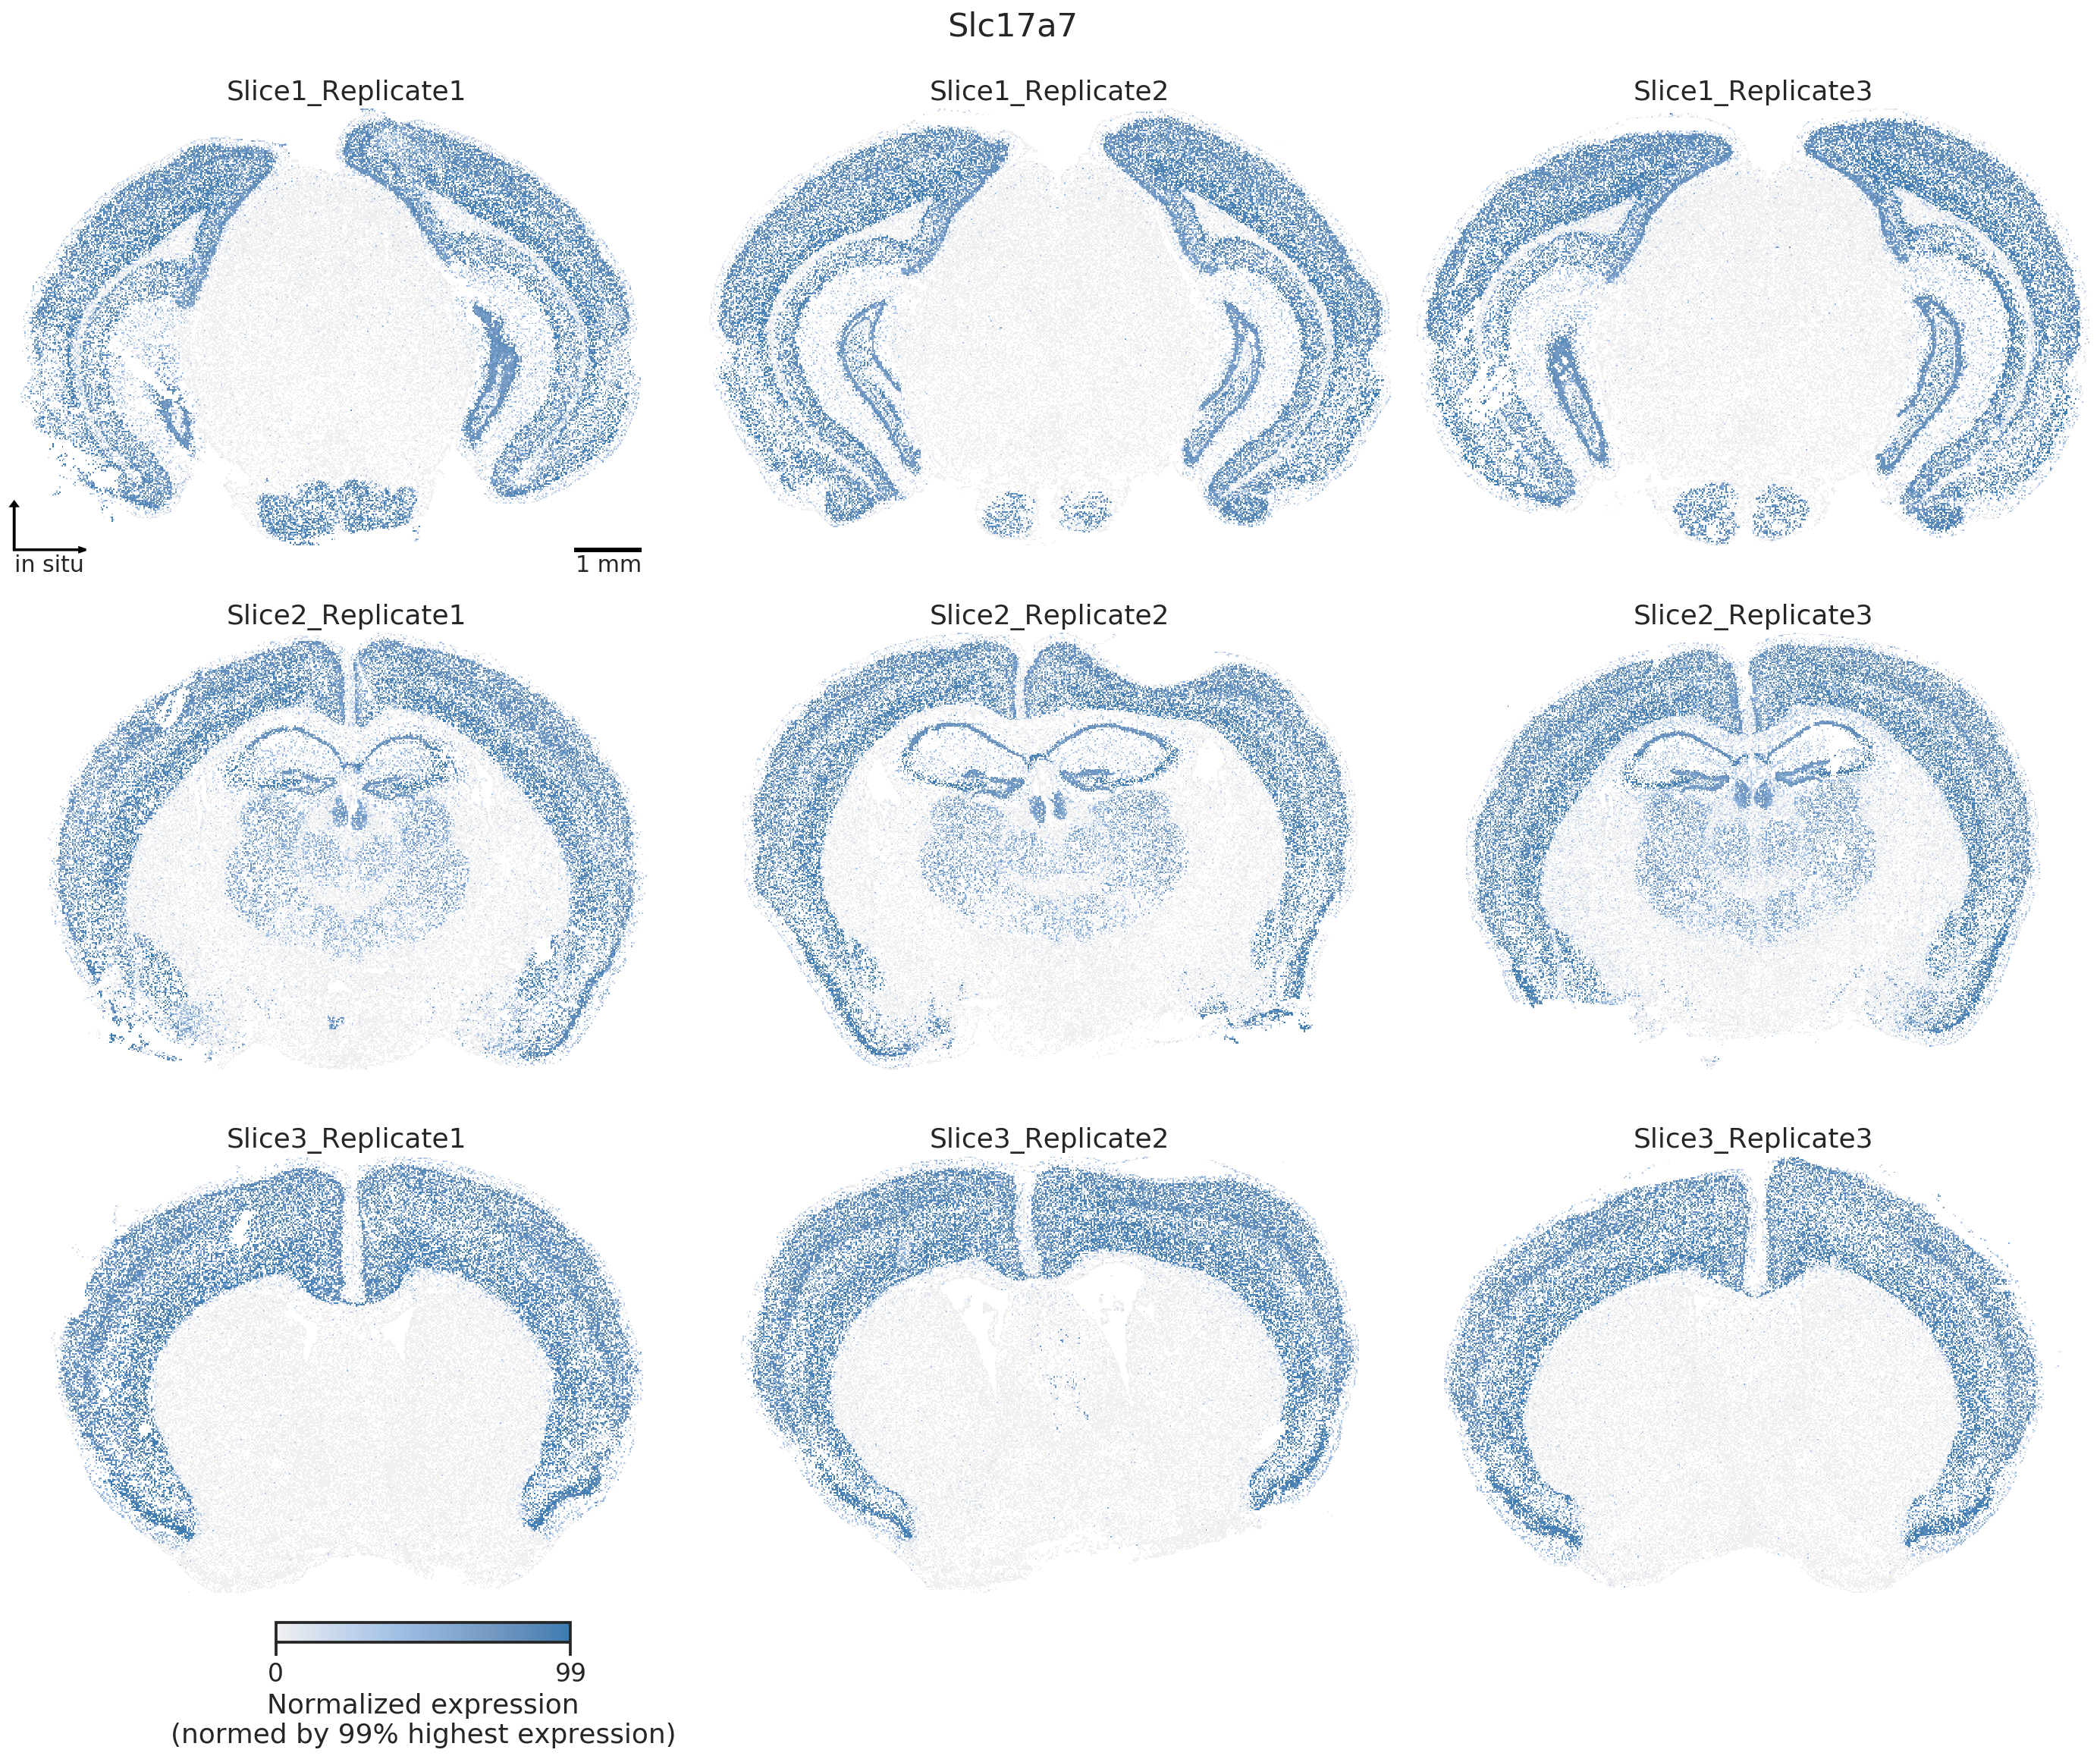

../figures/2021-05-29_9slices_Slc17a7.png


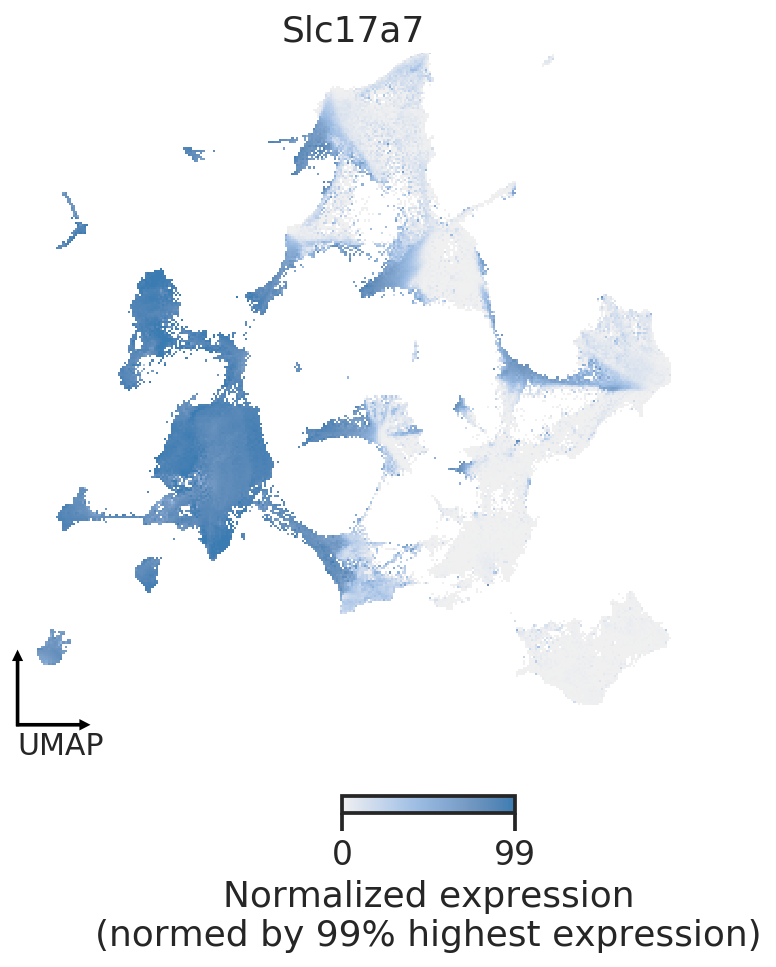

  0%|          | 0/1 [00:06<?, ?it/s]

../figures/2021-05-29_9slices_UMAP_Slc17a7.png


In [8]:
# run genes view
selected_genes = ['Slc17a7']
for gene in tqdm.tqdm(selected_genes):
    # insitu 
    x, y, hue = 'x', 'y', gene
    output = figures.format("9slices_"+gene+".png")
    
    fig_plot_gene_insitu_routine(
        thedatagmat, samples, x, y, hue, 
#         output=output, 
#         close=True,
        output='', 
        close=False,
        )
    print(output)
    
    # umap
    x, y, hue = 'umap_1', 'umap_2', gene
    output = figures.format("9slices_UMAP_"+gene+".png")
    
    fig_plot_gene_umap_routine(
        thedatagmat, x, y, hue, 
#         output=output,
#         close=True,
        output='',
        close=False,
        )
    print(output)
    break

### Run cluster viz (combined)

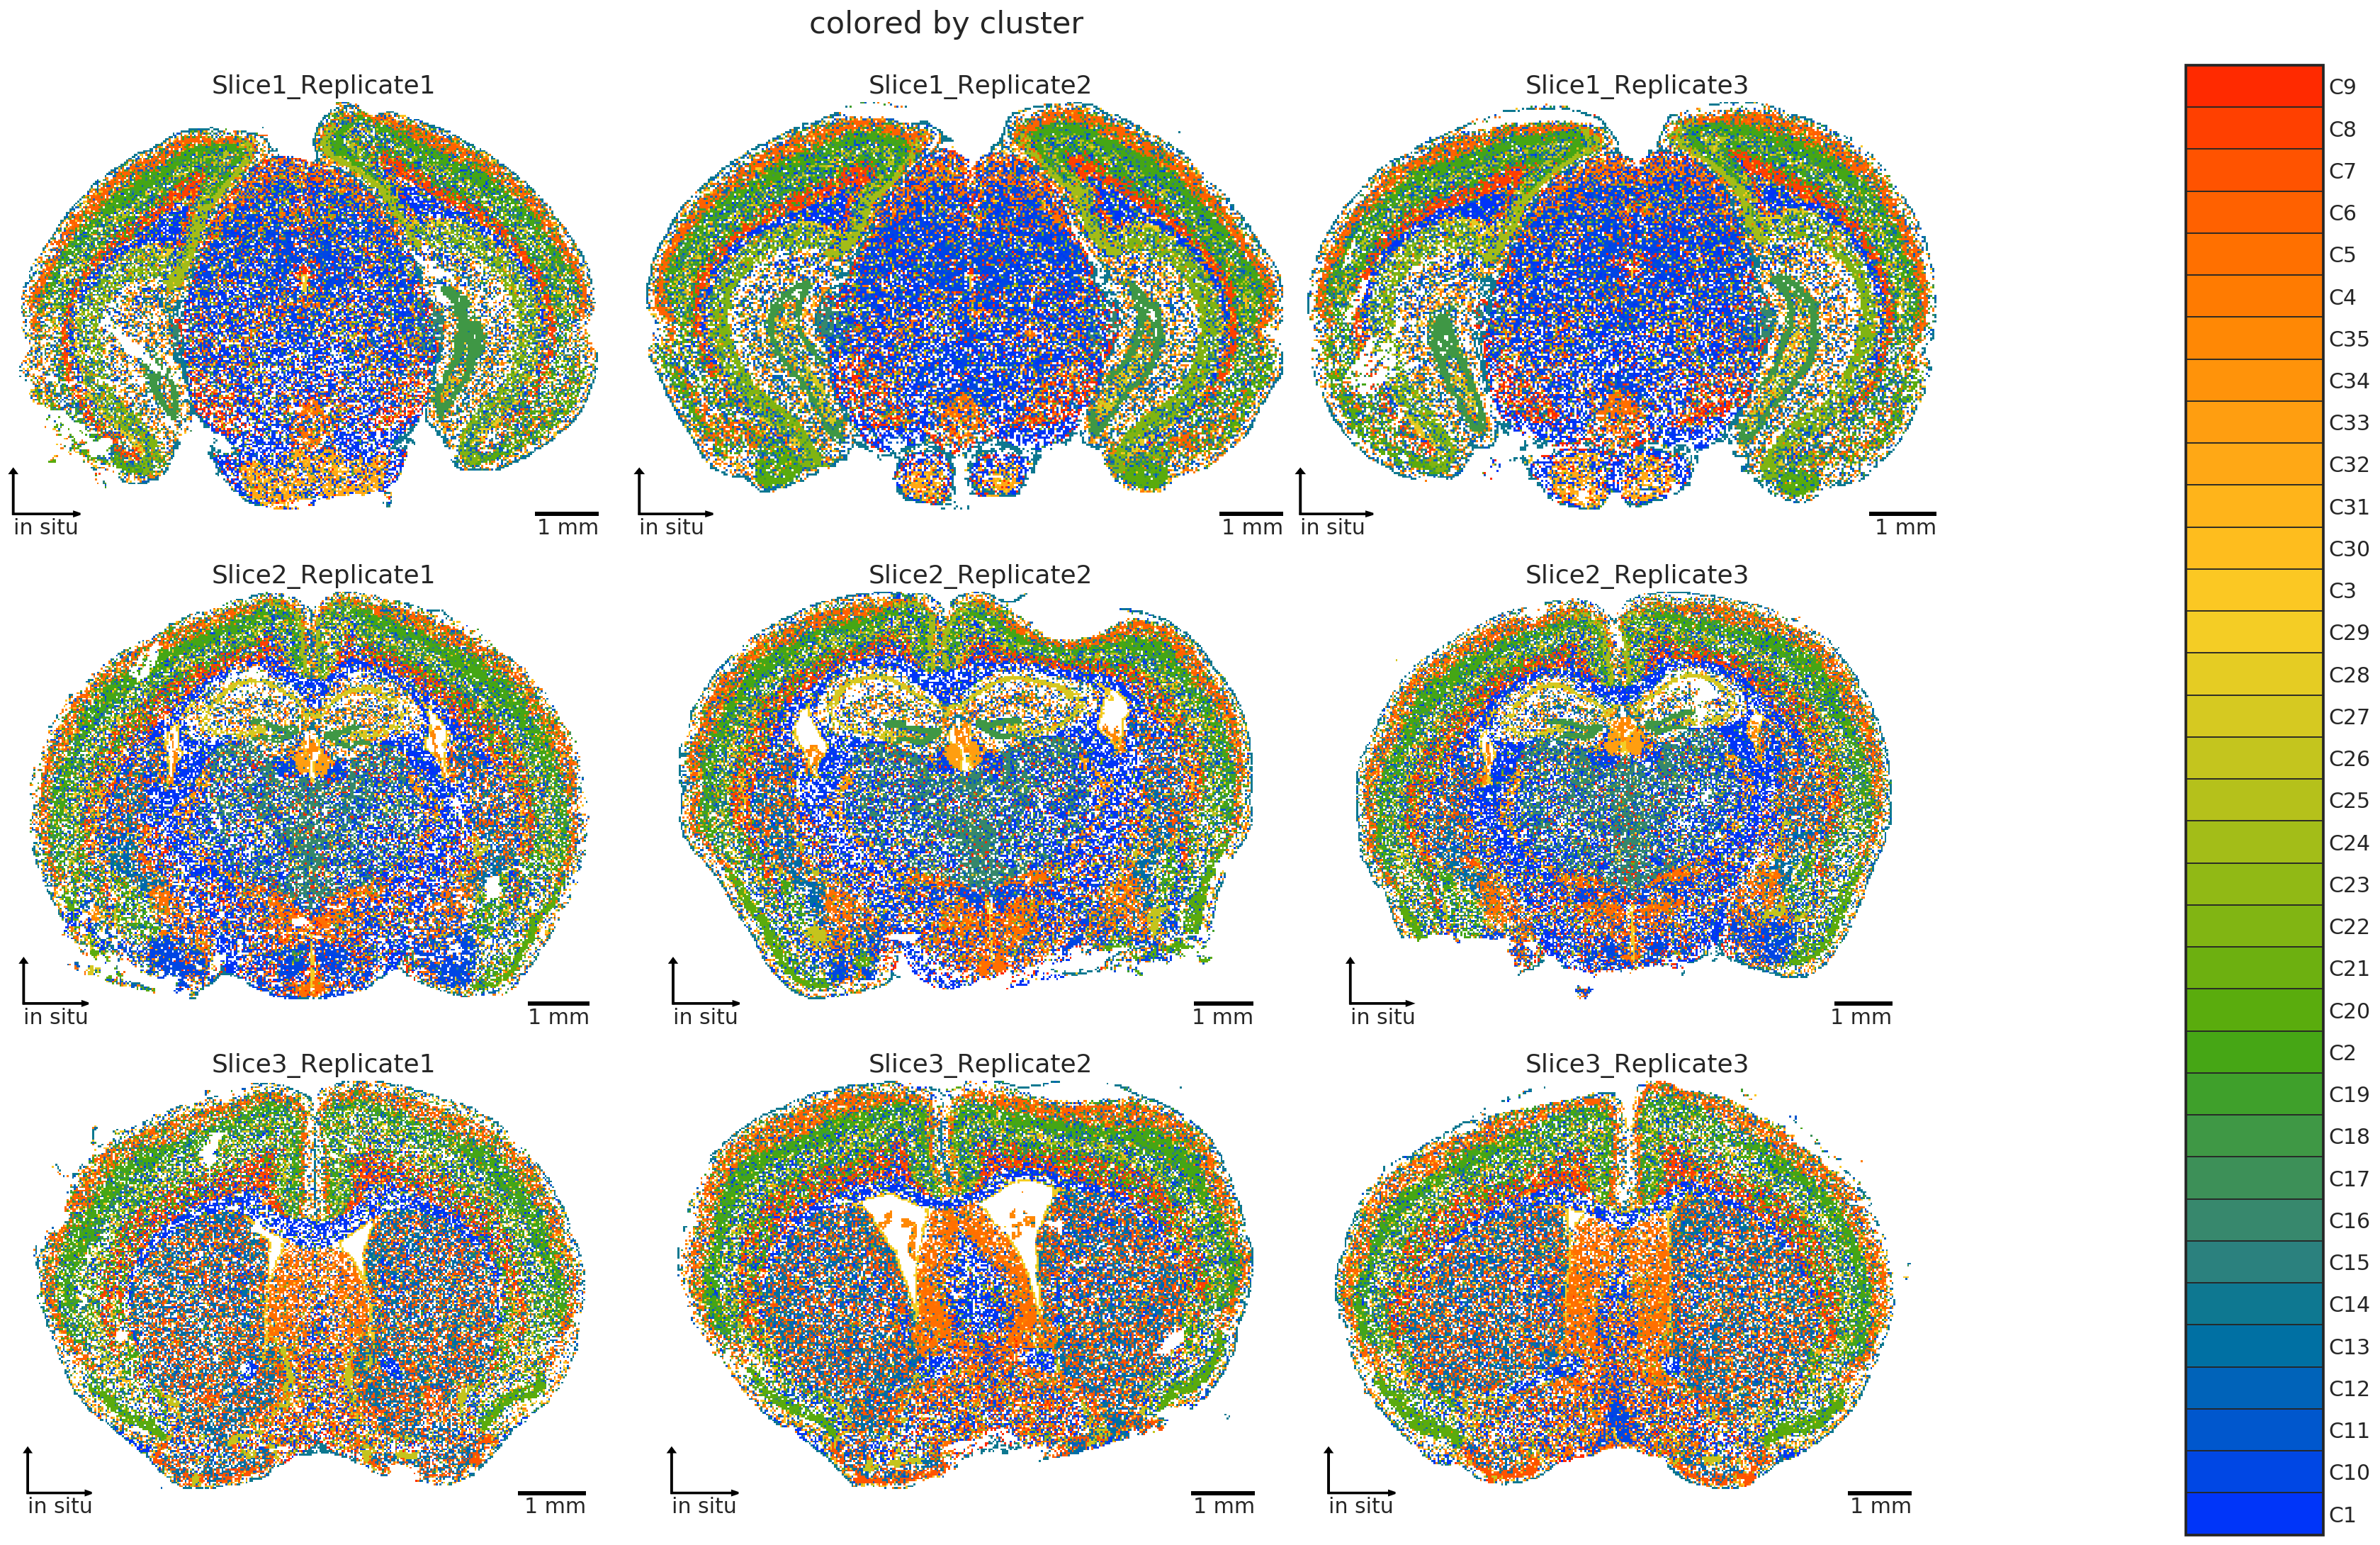

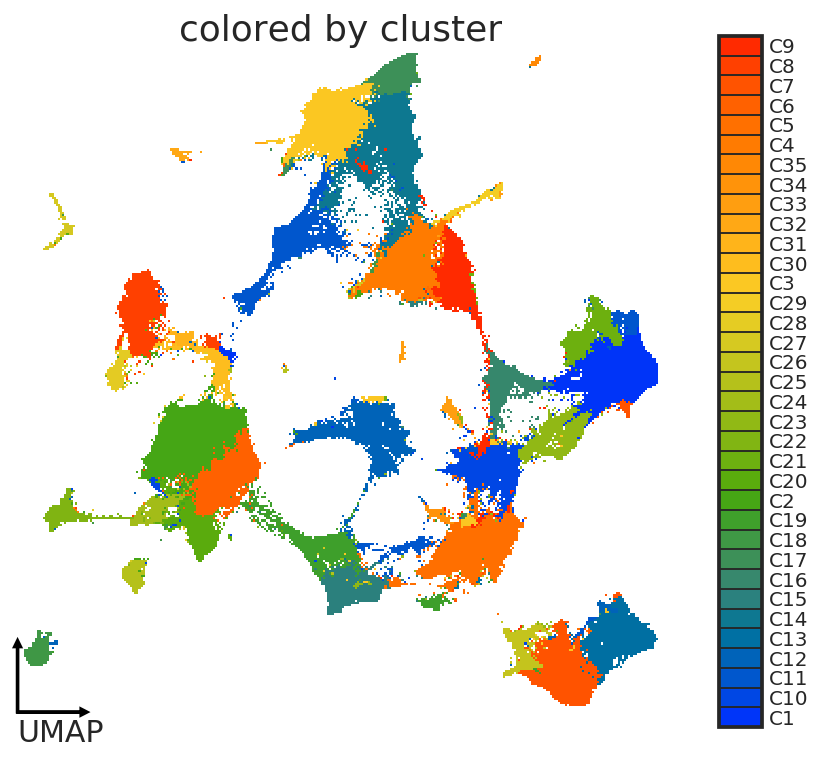

In [15]:
clusters = np.sort(thedata['cluster_cat'].cat.categories.values)
clstcolors_obj = powerplot.CategoricalColors(clusters)

# agg data for each sample
x, y, hue = 'x', 'y', 'cluster_cat'
suptitle = 'colored by cluster' 
output = figures.format("9slices_insitu_allclsts"+".png")
close = False
    
fig_plot_cluster_insitu_routine(
    thedata, samples, x, y, hue,
    clstcolors_obj,
    suptitle=suptitle,
    close=close,
    output=output, 
    ) 

# plot all clusters UMAP
x, y, hue = 'umap_1', 'umap_2', 'cluster_cat'
title = 'colored by cluster' 
output = figures.format("9slices_umap_allclsts"+".png")
close = False
fig_plot_cluster_umap_routine(
    thedata, x, y, hue,
    clstcolors_obj,
    title=title,
    close=close,
    output=output,
    )

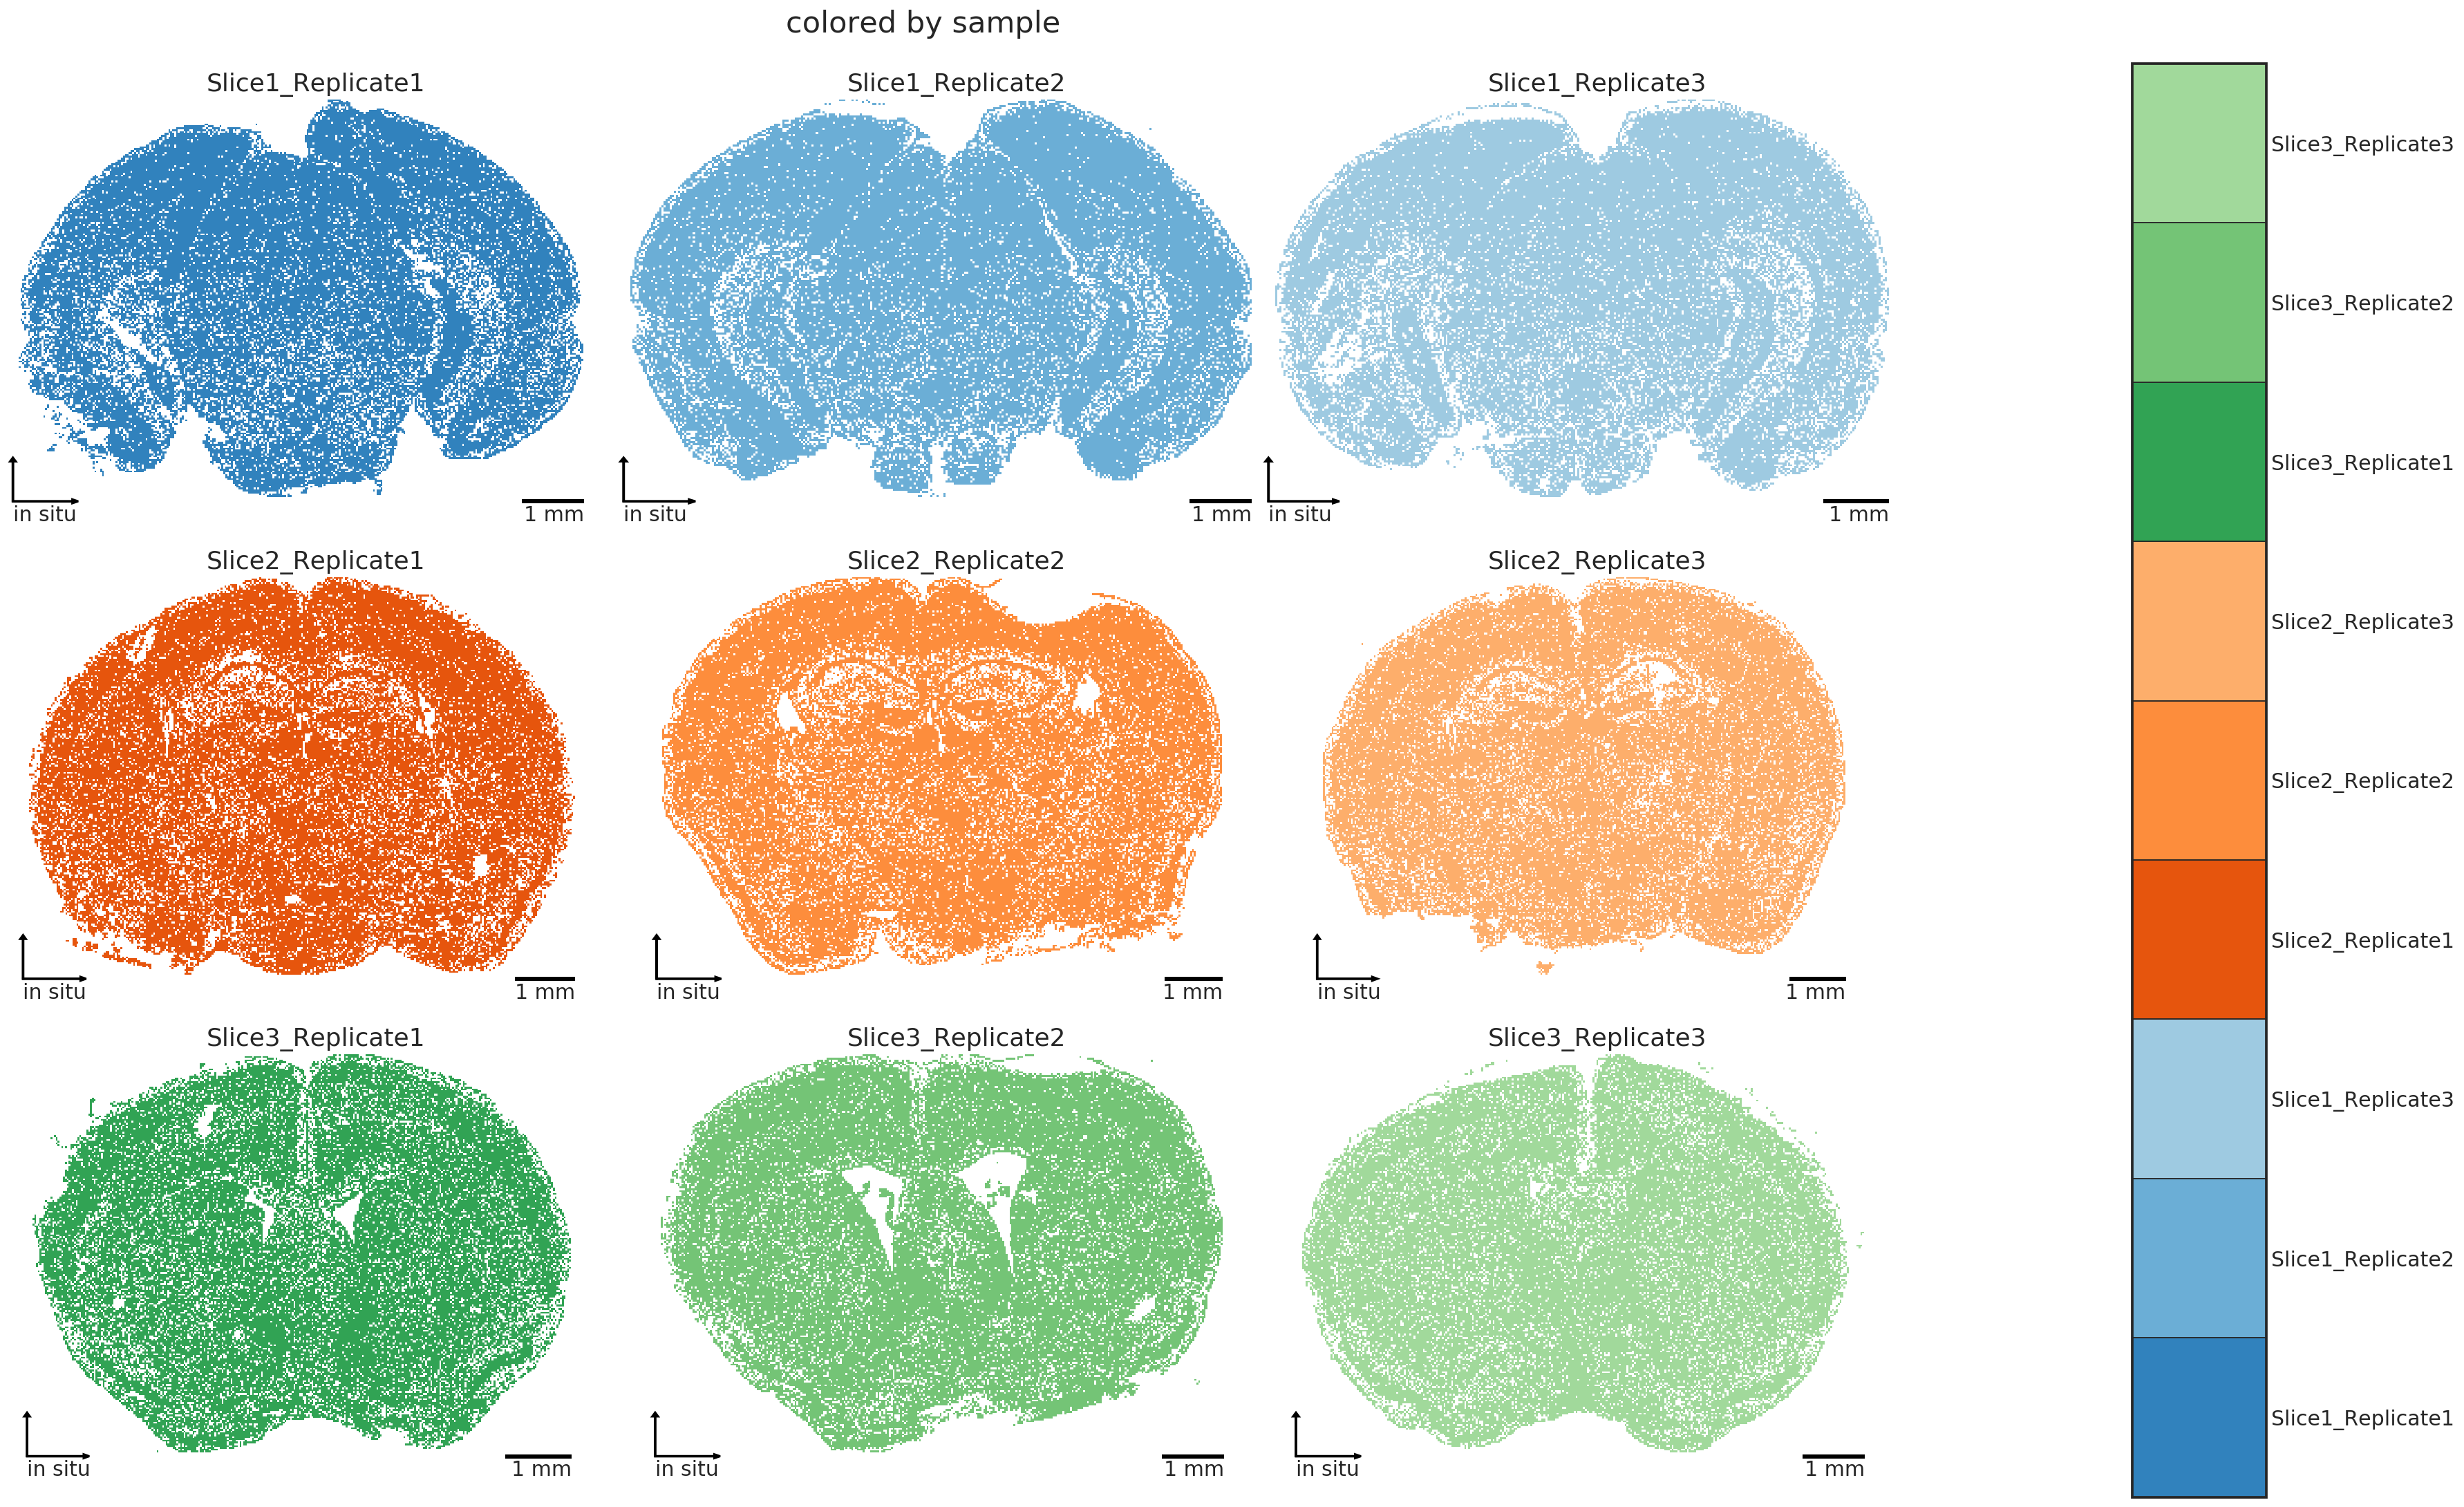

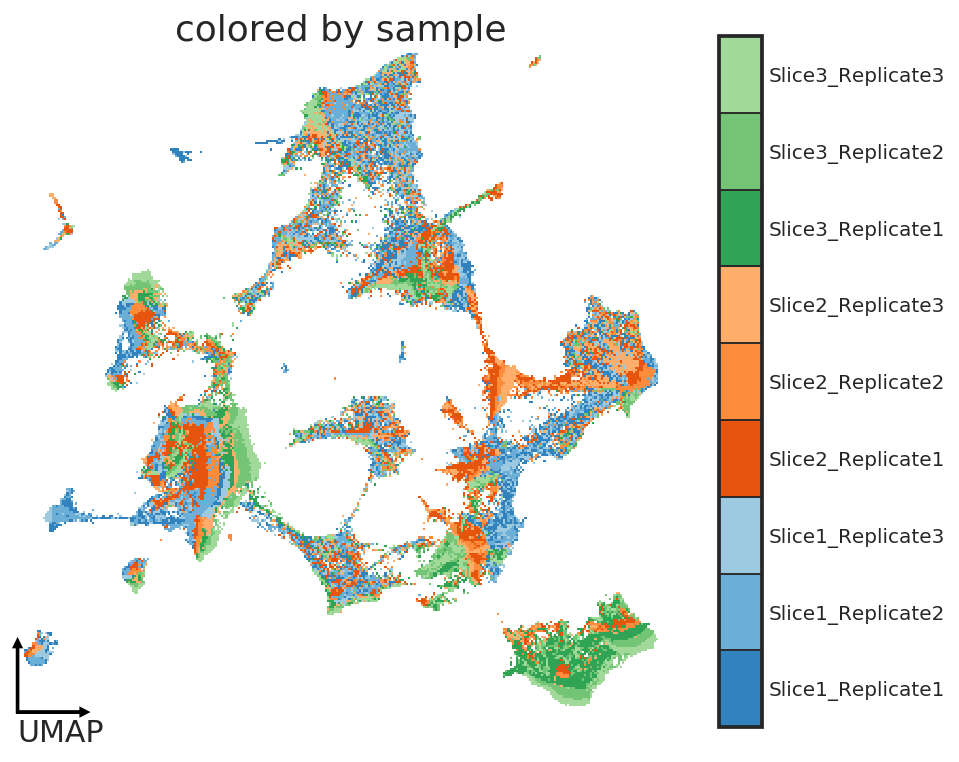

In [20]:
cat_col = 'sample_cat'
thedata[cat_col] = pd.Categorical(thedata['sample'])
categories = np.sort(thedata[cat_col].cat.categories.values)
clstcolors_obj = powerplot.CategoricalColors(categories, [palette[catg] for catg in categories])

# agg data for each sample
x, y, hue = 'x', 'y', cat_col
suptitle = 'colored by sample' 
output = figures.format("9slices_insitu_allclsts_"+cat_col+".png")
close = False
fig_plot_cluster_insitu_routine(
    thedata, samples, x, y, hue,
    clstcolors_obj,
    suptitle=suptitle,
    close=close,
    output=output, 
    ) 

# plot all clusters UMAP
x, y, hue = 'umap_1', 'umap_2', cat_col
title = 'colored by sample'
output = figures.format("9slices_umap_allclsts_"+cat_col+".png")
close = False
fig_plot_cluster_umap_routine(
    thedata, x, y, hue,
    clstcolors_obj,
    title=title,
    close=close,
    output=output,
    )

### Run cluster viz (one-by-one)
- a bit clumsy

In [10]:
# agg data for each sample
ps_aggdata_insitu_allsamples = collections.OrderedDict({})
x, y, hue = 'x', 'y', 'cluster_cat'
scale_paras = dict(pxl_scale=20)

# agg data for each sample
for sample in tqdm.tqdm(samples):
    data = thedatagmat[thedatagmat['sample']==sample]
    aggdata, ps, _ = powerplot.agg_count_cat(data, x, y, hue, scale_paras, clip_max=1)
    ps_aggdata_insitu_allsamples[sample] = (aggdata, ps)

100%|██████████| 9/9 [00:01<00:00,  4.92it/s]


In [11]:
# then plot for each cluster
nx = 3
ny = 3
figsize=(9*3,6*3)
cmap = colorcet.cm.blues
close = True
clusters = thedatagmat[hue].cat.categories.values

# then plot for each cluster
for clst in tqdm.tqdm(clusters):
    zlabel = clst
    output = figures.format("9slices_"+clst+".png")
    fig, axs = plt.subplots(ny, nx, figsize=figsize)
    for i, (ax, sample) in enumerate(zip(axs.flat, samples)):
        if i == 0:
            configs = dict(
                arrows=True,
                scalebar=True,
                )
        else:
            configs = dict(
                arrows=False,
                scalebar=False,
                )
        title = sample
        aggdata, ps = ps_aggdata_insitu_allsamples[sample]
        powerplot.plot_cluster_insitu_routine(
            ax, ps, aggdata, 
            hue, zlabel, title, cmap, 
            **configs,
            )
    fig.subplots_adjust(wspace=-0.2)
    fig.suptitle(zlabel, y=0.93)
    
    if output:
        utils.savefig(fig, output)
    if close:
        plt.close()
    else:
        plt.show()
        
#     break

100%|██████████| 35/35 [03:16<00:00,  5.60s/it]


In [12]:
# agg data for each sample
x, y, hue = 'umap_1', 'umap_2', 'cluster_cat'
scale_paras = dict(npxlx=300)
aggdata_umap, ps_umap, _ = powerplot.agg_count_cat(thedatagmat, x, y, hue, scale_paras, clip_max=1)

In [13]:
# then plot for each cluster
figsize=(6,6)
cmap = colorcet.cm.blues
clusters = thedatagmat[hue].cat.categories.values
close = True

# then plot for each cluster
for clst in tqdm.tqdm(clusters):
    zlabel = clst
    output = figures.format("9slices_umap_"+clst+".png")
    fig, ax = plt.subplots(figsize=figsize)
    title = sample
    ps, aggdata = ps_umap, aggdata_umap
    powerplot.plot_cluster_umap_routine(
        ax, ps, aggdata, 
        hue, zlabel, title, cmap, 
        arrows=True,
        )
    ax.set_title(zlabel)
    
    if output:
        utils.savefig(fig, output)
    if close:
        plt.close()
    else:
        plt.show()
        
#     break

100%|██████████| 35/35 [00:15<00:00,  2.28it/s]
